<a href="https://colab.research.google.com/github/RuwanPradeep0/Plant-disease-detection-model-Deep-Learning-Mini-project/blob/main/Plant%20disease%20detection_01_Transfer%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np;
import matplotlib.pyplot as plt;
import tensorflow as tf;
import time;

In [2]:
dataset_path = "/content/dataset"

In [3]:
BATCH_SIZE = 18;
IMAGE_SIZE = (232 , 148);

In [4]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

remaining_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# Calculate sizes
validation_size = tf.data.experimental.cardinality(remaining_data).numpy() // 2
test_size = validation_size

validation_data = remaining_data.take(validation_size)
test_data = remaining_data.skip(validation_size)

Found 410 files belonging to 2 classes.
Using 287 files for training.
Found 410 files belonging to 2 classes.
Using 123 files for validation.


In [8]:
class_name = train_data.class_names
print(class_name)

['Diseased', 'Healthy']


In [6]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(18, 232, 148, 3)
[0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]


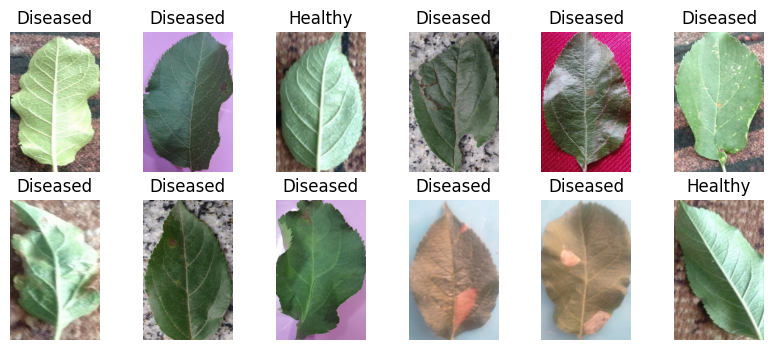

In [9]:
# plot data sample
plt.figure(figsize=(10,4))
for i in range(12):
    ax = plt.subplot(2,6,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_name[label_batch[i]])
    plt.axis("off")

**Scaling Images**

In [10]:
for image,label in train_data.take(1):
    for i in range(1):
      print(image)

tf.Tensor(
[[[[186.       125.       202.      ]
   [186.       125.       202.      ]
   [186.       125.       202.      ]
   ...
   [196.       134.       211.      ]
   [196.       134.       211.      ]
   [196.       134.       211.      ]]

  [[186.       125.       202.      ]
   [186.       125.       202.      ]
   [186.       125.       202.      ]
   ...
   [196.       134.       211.      ]
   [196.       134.       211.      ]
   [196.       134.       211.      ]]

  [[186.       125.       202.      ]
   [186.       125.       202.      ]
   [186.       125.       202.      ]
   ...
   [196.       134.       211.      ]
   [196.       134.       211.      ]
   [196.       134.       211.      ]]

  ...

  [[177.       116.       194.      ]
   [177.       116.       194.      ]
   [175.9038   114.9038   192.77203 ]
   ...
   [195.04095  133.04095  210.04095 ]
   [195.04095  133.04095  210.04095 ]
   [195.04095  133.04095  210.04095 ]]

  [[177.       116.       194.    

In [11]:

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(232,148,3)),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
  ]
)


**Transfer Learning**

In [64]:
# Load the pre-trained model
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(232, 148, 3),
    include_top=False,
    weights='imagenet'
)

In [65]:
# Freeze the base model
base_model.trainable = False

In [66]:
# Add a custom classifier on top of the base model
model = tf.keras.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

In [67]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [68]:
# Summary of the model
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 232, 148, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 2)                

**Train the Model**

In [69]:
start_time = time.time()

EPOCHS = 4
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=EPOCHS
)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")


Epoch 1/4
16/16 [==============================] - 13s 595ms/step - loss: 0.4166 - accuracy: 0.8641 - val_loss: 0.2065 - val_accuracy: 0.9259
Epoch 2/4
16/16 [==============================] - 8s 500ms/step - loss: 0.2559 - accuracy: 0.8955 - val_loss: 0.2048 - val_accuracy: 0.9074
Epoch 3/4
16/16 [==============================] - 8s 502ms/step - loss: 0.2197 - accuracy: 0.9024 - val_loss: 0.0797 - val_accuracy: 0.9630
Epoch 4/4
16/16 [==============================] - 9s 517ms/step - loss: 0.2458 - accuracy: 0.8850 - val_loss: 0.1975 - val_accuracy: 0.9444
Elapsed time: 40.29 seconds


**Performance Analysis**

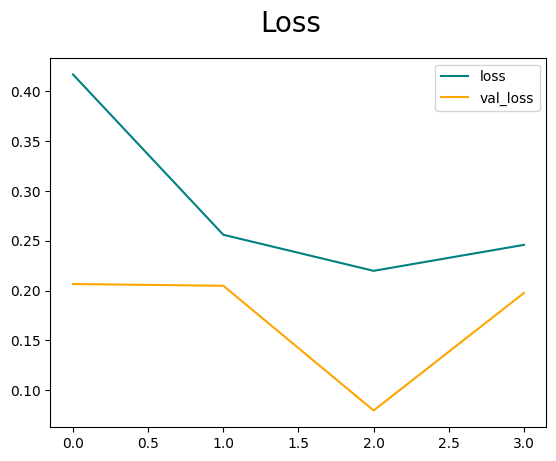

In [70]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend()
plt.show()


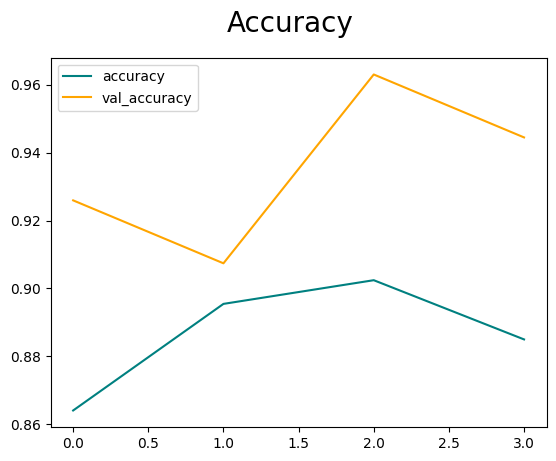

In [71]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend()
plt.show()


**Testing**

In [78]:
import cv2

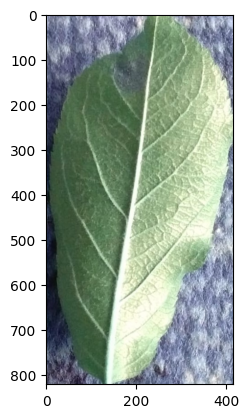

In [82]:
img = cv2.imread('/content/dataset/Diseased/1013.JPG.jpeg')
plt.imshow(img)
plt.show()


In [83]:
resized_image = tf.image.resize(img, IMAGE_SIZE)
scaled_image = resized_image/255


In [84]:
scaled_image.shape

TensorShape([232, 148, 3])

In [85]:
np.expand_dims(scaled_image, 0).shape

(1, 232, 148, 3)

In [86]:
yhat = model.predict(np.expand_dims(scaled_image, 0))

1/1 [==============================] - 0s 63ms/step


In [87]:
yhat

array([[0.9173081 , 0.08269197]], dtype=float32)

In [95]:
predicted_class = np.argmax(yhat, axis=1)
print(f'{class_name[predicted_class[0]]}')

Diseased
